# Сборный проект — 2

<a id='section_id'></a>
## Содержание 
[Задача 1: предсказание уровня удовлетворённости сотрудника](#section_id1)

[____Шаг 1. Загрузка данных](#section_id2)

[____Шаг 2. Предобработка данных](#section_id3)

[____Шаг 3. Исследовательский анализ данных](#section_id4)

[____Шаг 4. Подготовка данных](#section_id5)

[____Шаг 5. Обучение моделей](#section_id6)

[____Шаг 6. Оформление выводов](#section_id7)

[Задача 2: предсказание увольнения сотрудника из компании](#section_id8)

[____Шаг 1. Загрузка данных](#section_id9)

[____Шаг 2. Предобработка данных](#section_id10)

[____Шаг 3. Исследовательский анализ данных](#section_id11)
    
[____Шаг 4. Добавление нового входного признака](#section_id12)

[____Шаг 5. Подготовка данных](#section_id13)

[____Шаг 6. Обучение модели](#section_id14)

[____Шаг 7. Выводы](#section_id15)

[Общий вывод](#section_id16)

## Описание исследования

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

**Первая задача** — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

**Вторая задача** — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Цели исследования

- Разработать решение для определения уровня удовлетворенности сотрудника;
- Разработать решение для предсказания увольнения сотрудника.

## Ход исследования

1. Получение данных
2. Предобработка данных
3. Исследовательский анализ
4. Подготовка данных
5. Обучение моделей
6. Выводы

<a id='section_id1'></a>
## Задача 1: предсказание уровня удовлетворённости сотрудника
[к содержанию](#section_id)

In [1]:
# установка билиотек
!pip install shap -q
!pip install phik -q
!pip install -Uq scikit-learn # Эта библиотека обновлялась вместе с установкой imblearn

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np

# импорт моделей для подготовки и обработки данных
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from phik.report import plot_correlation_matrix
from phik import phik_matrix

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импорт моделей машинного обучения
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC

# импорт инструментов управления ресурсами
import joblib
import time

# импорт инструментов поиска
from sklearn.model_selection import GridSearchCV

# импорт метрик
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import roc_auc_score

# импорт инструментов анализа
import shap

# импорт графических библиотек
from matplotlib import pyplot as plt

In [3]:
# создание констант RANDOM_STATE и TEST_SIZE
RANDOM_STATE = 42
TEST_SIZE = 0.25

<a id='section_id2'></a>
### Шаг 1. Загрузка данных
[к содержанию](#section_id)

In [4]:
# загрузка данных тренировочной выборки
train_s = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', index_col='id')

In [5]:
# загрузка данных тестовой выборки
test_s = pd.read_csv('/datasets/test_features.csv', index_col='id')

In [6]:
# целевой признак тестовой выборки
target_s = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', index_col='id')

<a id='section_id3'></a>
### Шаг 2. Предобработка данных
[к содержанию](#section_id)

In [7]:
# функция для обзора данных
def preview(dataset):
    '''Функция принимает на вход набор данных и выводит основную информацию о нем.'''
    display(dataset.head())
    dataset.info()
    display(dataset.describe(include='all').T)

In [8]:
# обзор данных тренировочной выборки
preview(train_s)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dept,3994,5,sales,1512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,3996,3,junior,1894,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workload,4000,3,medium,2066,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_years,4000.0,NaN,NaN,NaN,3.7185,2.542513,1.0,2.0,3.0,6.0,10.0
last_year_promo,4000,2,no,3880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_year_violations,4000,2,no,3441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
supervisor_evaluation,4000.0,NaN,NaN,NaN,3.4765,1.008812,1.0,3.0,4.0,4.0,5.0
salary,4000.0,NaN,NaN,NaN,33926.7,14900.703838,12000.0,22800.0,30000.0,43200.0,98400.0
job_satisfaction_rate,4000.0,NaN,NaN,NaN,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


In [9]:
# обзор данных тестовой выборки
preview(test_s)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dept,1998,6,sales,763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,1999,3,junior,974,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workload,2000,4,medium,1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_years,2000.0,NaN,NaN,NaN,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
last_year_promo,2000,2,no,1937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_year_violations,2000,2,no,1738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
supervisor_evaluation,2000.0,NaN,NaN,NaN,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0
salary,2000.0,NaN,NaN,NaN,34066.8,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0


In [10]:
# обзор данных целевого признака тестовой выборки
preview(target_s)

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,2000.0,0.54878,0.22011,0.03,0.38,0.58,0.72,1.0


In [11]:
# проверка на наличие пропусков train_s
train_s.isna().sum()

dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [12]:
# проверка на наличие пропусков test_s
test_s.isna().sum()

dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Пропуски будут устранены в pipeline

In [13]:
# проверка train_s на наличие явных дубликатов
train_s.duplicated().sum()

245

In [14]:
# удаление явных дубликатов train_s
print('Сотрудников до удаления:', len(train_s))
train_s = train_s.drop_duplicates()
print('Сотрудников после удаления:', len(train_s))

Сотрудников до удаления: 4000
Сотрудников после удаления: 3755


In [15]:
# исправление опечатки
train_s['level'] = train_s['level'].str.replace('sinior', 'senior')
test_s['level'] = test_s['level'].str.replace('sinior', 'senior')

In [16]:
# проверка test_s на неизвестные значения
print(test_s['dept'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']


In [17]:
# обработка неизвестных значений в категориях dept
test_s['dept'] = test_s['dept'].str.replace(' ', train_s['dept'].mode()[0])

Неизвестные значения будут заменены в пайплайне на np.nan до кодирования, а затем, на наиболее часто встречающиеся значения после кодирования

<a id='section_id4'></a>
### Шаг 3. Исследовательский анализ данных
[к содержанию](#section_id)

In [18]:
# исследование признаков
display(train_s.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dept,3749,5,sales,1374,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,3751,3,junior,1699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workload,3755,3,medium,1908,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_years,3755.0,NaN,NaN,NaN,3.817044,2.557142,1.0,2.0,3.0,6.0,10.0
last_year_promo,3755,2,no,3635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_year_violations,3755,2,no,3202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
supervisor_evaluation,3755.0,NaN,NaN,NaN,3.463648,1.026265,1.0,3.0,4.0,4.0,5.0
salary,3755.0,NaN,NaN,NaN,34457.416778,15050.64387,12000.0,22800.0,31200.0,44400.0,98400.0
job_satisfaction_rate,3755.0,NaN,NaN,NaN,0.532554,0.226393,0.03,0.35,0.55,0.71,1.0


**dept** - категориальный признак, предпочтительно кодирование OHE

**level** - категориальный, порядковый признак, предпочтительно кодирование OrdinalEncoder

**workload** - категориальный, порядковый признак, предпочтительно кодирование OrdinalEncoder

**employment_years** - количественный признак, необходимо произвести масштабирование

**last_years_promo** - категориальный признак, предпочтительно кодироание OHE

**supervisor_evaluation** - количественный признак, необходимо произвести масштабирование

**salary** - количественный признак, необходимо произвести масштабирование

**job_satisfaction_rate** - целевой количественный признак, в пределах от 0.0 до 1.0, не нуждается в обработке

In [19]:
# функция для построения графиков
def plt_chart(data, cols, kind):
    '''Функция принимает на вход набор данных, список столбцов, тип графика.
    Строит графики признаков набора данных.'''
    fig, ax = plt.subplots(ncols=len(cols), figsize=(15, 5))
    
    try:
        for i, a in enumerate(ax):
            data[cols[i]].plot(ax=a,
                                 kind=kind,
                                 title=cols[i],
                                 xlabel=cols[i])
    except:
        for i, a in enumerate(ax):
            data[cols[i]].value_counts().plot(ax=a,
                                 kind=kind,
                                 title=cols[i],
                                 xlabel=cols[i])
    plt.suptitle('Графики признаков')
    plt.show()

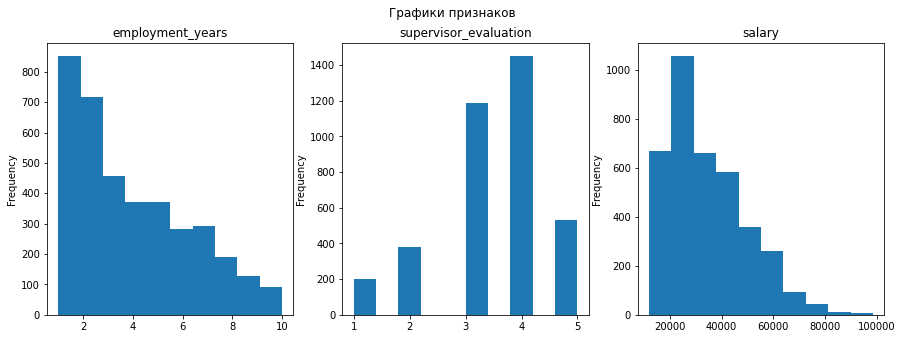

In [20]:
# гистограммы количественных признаков
num_cols = ['employment_years',
            'supervisor_evaluation',
            'salary']

plt_chart(train_s, num_cols, 'hist')

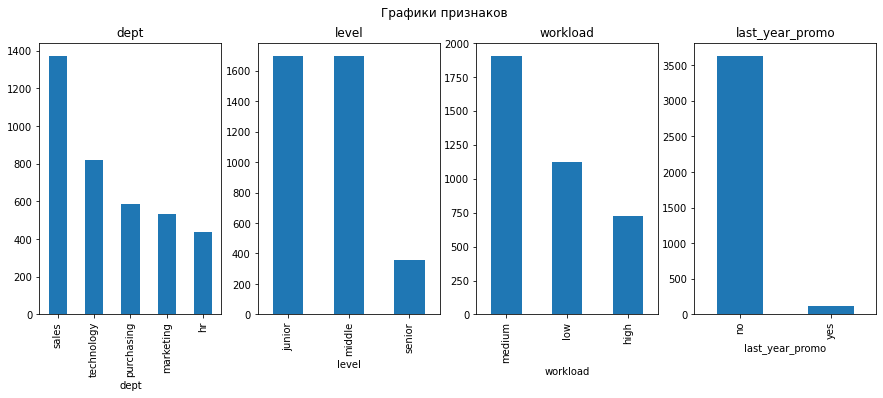

In [21]:
# столбчаты диаграммы категориальных признаков
cat_cols = ['dept',
            'level',
            'workload',
            'last_year_promo']

plt_chart(train_s, cat_cols, kind='bar')

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


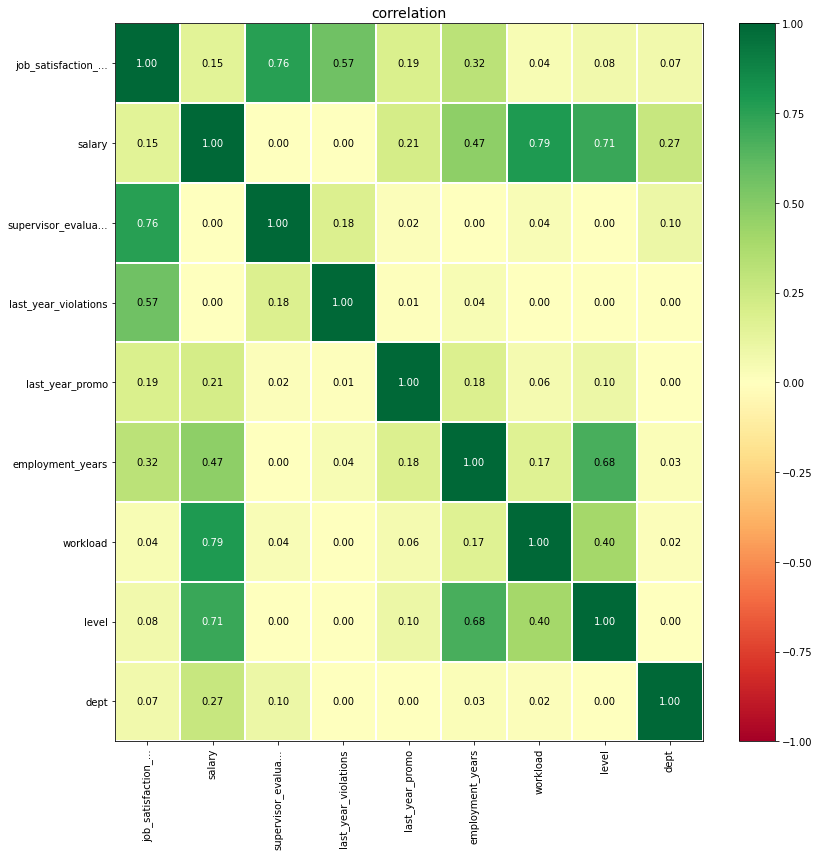

In [22]:
# анализ корреляционных зависимостей между признаками
phik_overview = train_s.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(12, 12)
)

Мультиколлинеарности среди признаков не обнаружено.

Сильнее всего на целевой признак влияют: supervisor_evaluation, last_year_violation, employment_years

In [23]:
# исследование признаков
display(test_s.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dept,1998,5,sales,764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,1999,3,junior,974,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workload,2000,4,medium,1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_years,2000.0,NaN,NaN,NaN,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
last_year_promo,2000,2,no,1937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_year_violations,2000,2,no,1738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
supervisor_evaluation,2000.0,NaN,NaN,NaN,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0
salary,2000.0,NaN,NaN,NaN,34066.8,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0


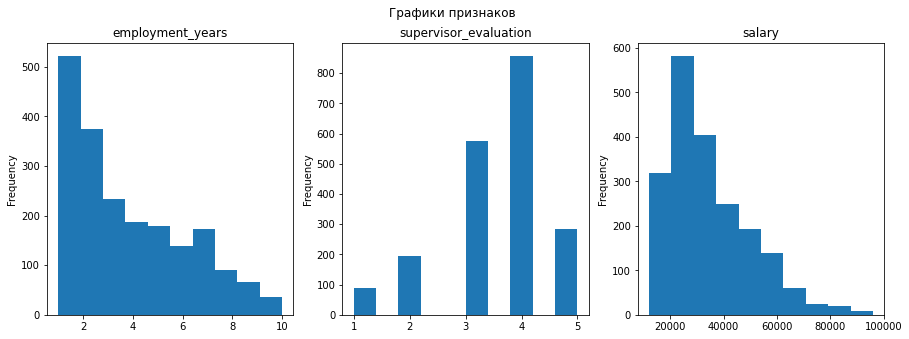

In [24]:
# гистограммы количественных признаков тестовой выборки
plt_chart(test_s, num_cols, 'hist')

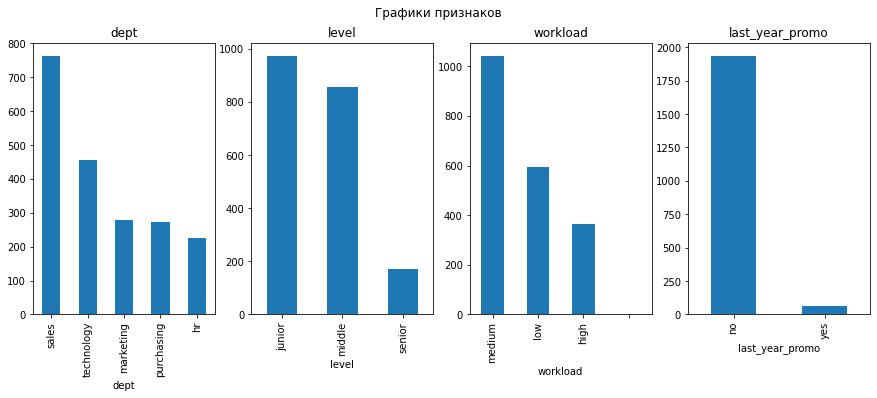

In [25]:
# столбчатые диаграммы категориальных признаков тестовой выборки
plt_chart(test_s, cat_cols, kind='bar')

**Вывод:** тренировочная и тестовая выборки практически не отличаются по распределению признаков

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary']


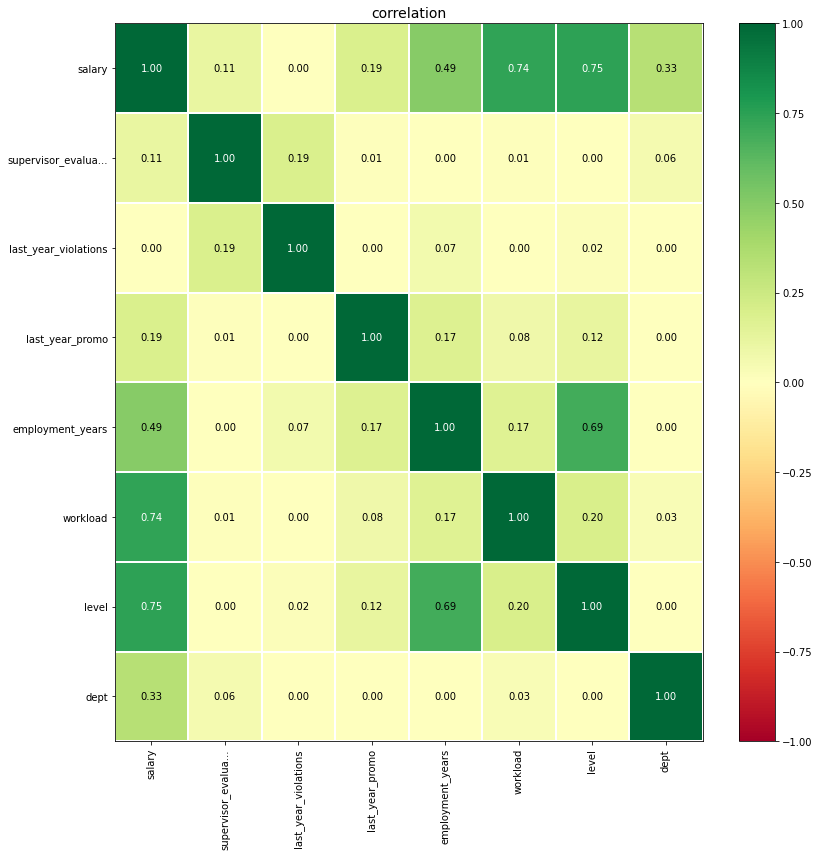

In [26]:
# анализ корреляционных зависимостей между признаками тестовой выборки
phik_overview = test_s.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(12, 12)
)

**Вывод:** Однако, в тестовой выборке на целевой признак больше оказывают влияние не supervisor_evaluation и last_year_violations, а workload, level и employment_years

<a id='section_id5'></a>
### Шаг 4. Подготовка данных
[к содержанию](#section_id)

In [27]:
# задание тренировочной и тестовой выборки
X_train = train_s.drop(['job_satisfaction_rate'], axis=1).sort_index()
X_test = test_s.sort_index()
y_train = train_s['job_satisfaction_rate'].sort_index()
y_test = target_s.sort_index()

X_train.shape, X_test.shape

((3755, 8), (2000, 8))

In [28]:
# создание списков с названиями признаков
ohe_columns = ['dept',
              'last_year_promo',
              'last_year_violations']
ord_columns = ['level',
               'workload']
num_columns = ['employment_years',
               'supervisor_evaluation',
               'salary']

In [29]:
# пайплайн для кодирования ohe_columns + SimpleImputer для заполнения пропусков
ohe_pipe = Pipeline(
    [
     ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [30]:
# пайплайн для кодирования ord_columns + SimpleImputer для заполнения пропусков
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(categories=[['junior', 'middle', 'senior'],
                                         ['low', 'medium', 'high']],
                             handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )

In [31]:
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

<a id='section_id6'></a>
### Шаг 5. Обучение моделей
[к содержанию](#section_id)

In [32]:
# итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [33]:
# задание параметров для пайплайна
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_features': range(8, 10),
        'models__max_depth': range(20, 25),
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели Ridge()
    {
        'models': [Ridge()],
        'models__alpha': [0.1, 1.0, 10.0, 100.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели Lasso()
    {
        'models': [Lasso()],
        'models__alpha': [0.1, 1.0, 10.0, 100.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели KNeighborsRegressor()
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [34]:
# создание метрики SMAPE
def smape(y_true, y_pred):
    metric = round(((100/len(y_true)) * 
    (np.abs(y_pred - y_true) / 
    ((np.abs(y_true) + np.abs(y_pred))/2)).sum()), 2)
    return metric

# создаём пользовательскую метрику
smape_scorer = make_scorer(smape, greater_is_better=False)

In [35]:
# инициализация подбора параметров
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)

In [36]:
# настройка библиотеки для работы с многопоточными вычислениями
joblib.parallel_backend('threading')

In [37]:
# запуск подбора параметров
start_time = time.time()
grid_search.fit(X_train, y_train)
total_time = time.time() - start_time

print(f"Время поиска: {total_time:.2f} seconds")
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Время поиска: 79.95 seconds
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',


In [38]:
# вывод лучших моделей
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)

params_top_10 = results.iloc[0:10]['params']
for param in params_top_10:
    print(param)

{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 20, 'models__max_features': 9, 'models__min_samples_leaf': 2, 'models__min_samples_split': 4, 'preprocessor__num': StandardScaler()}
{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 20, 'models__max_features': 9, 'models__min_samples_leaf': 2, 'models__min_samples_split': 3, 'preprocessor__num': StandardScaler()}
{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 20, 'models__max_features': 9, 'models__min_samples_leaf': 2, 'models__min_samples_split': 2, 'preprocessor__num': StandardScaler()}
{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 21, 'models__max_features': 9, 'models__min_samples_leaf': 2, 'models__min_samples_split': 3, 'preprocessor__num': StandardScaler()}
{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 24, 'models__max_features': 9, 'models__min_samples_leaf': 2, 'models__min_samples_split': 2, 'preprocessor_

**Анализ 10 лучших моделей:** в топ 10 моделей входят только модели DecisionTreeRegressor с различными параметрами max_depth и min_samples_split. Победила самая сложная модель из представленных.

In [39]:
# расчет метрики на тестовой выборке
y_test_pred = grid_search.predict(X_test)
print('Метрика лучшей модели на тестовой выборке:', smape(y_test, y_test_pred.reshape(-1, 1)).iloc[0])

Метрика лучшей модели на тестовой выборке: 14.31


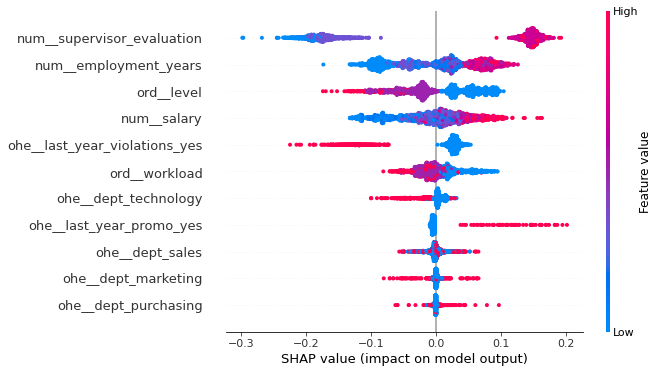

In [40]:
# построение графика важности признаков модели на основе shap
X_train_2 = grid_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
explainer = shap.Explainer(grid_search.best_estimator_.named_steps['models'], X_train_2)
X_test_2 = grid_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

shap_values = explainer(X_test_2, check_additivity=False)

shap.plots.beeswarm(shap_values, max_display=20) 

<a id='section_id7'></a>
### Шаг 6. Оформление выводов
[к содержанию](#section_id)

**Выводы:**

В данных были обнаружены и устранены проблемы: пропуски, опечатки.

Данные тренировочной, тестовой выборок и целевого признака были неотсортированы по 'id', в результате долго не получалось разобраться в причине "недообучения". Модель не могла уловить закономерности в "перемешанных данных".

На этапе исследовательского анализа было определено, что с целевым больше всего коррелируют признаки: 'supervisor_evaluation', 'last_year_violations', 'employment_years'.

В ходе обучения лучше справилась модель DecisionTreeRegressor(max_depth=20, max_features=9) с результатом SMAPE = 13.45. Модель получилась сложной, скорее всего потому, что тренировочная выборка была недостаточно большой.

Модель выделяет высокую важность признаков, и подтверждает предполагаемую на этапе разведочного анализа зависимость от:

**supervisor_evaluation** - чем больше значение признака, тем выше уровень удовлетворенности сотрудника, признак можно рассматривать как индикатор, не причину увеличения целевого признака

**employment_years** - чем больше работает сотрудник, тем больше уровень удовлетворенности,признак можно рассматривать, как индикатор

**salary** - уровень зарплаты, чем больше, тем выше удовлетворенность, этот признак может быть влияющим на целевой, так как зарплата относится к условиям труда

**level** - чем выше уровень сотрудника, тем ниже удовлетворенность, признак можно считать, что признак является индикатором. (Возможно, профессионалы уходят из компании, так как перерастают уровень своих должностных обязанностей, хотят решать какой-то определенный вид задач)

**last_year_violations** - если сотрудник нарушает трудовой договор, его удовлетворенность может быть низкой. Признак можно рассматривать, как индикатор для целевого.

<a id='section_id8'></a>
## Задача 2: предсказание увольнения сотрудника из компании
[к содержанию](#section_id)

### Описание данных

**id** — уникальный идентификатор сотрудника;

**dept** — отдел, в котором работает сотрудник;

**level** — уровень занимаемой должности;

**workload** — уровень загруженности сотрудника;

**employment_years** — длительность работы в компании (в годах);

**last_year_promo** — показывает, было ли повышение за последний год;

**last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;

**supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;

**salary** — ежемесячная зарплата сотрудника;

**quit** — увольнение сотрудника из компании.

<a id='section_id9'></a>
### Шаг 1. Загрузка данных
[к содержанию](#section_id)

In [41]:
# загрузка данных тренировочной выборки
train_q = pd.read_csv('/datasets/train_quit.csv', index_col='id')

In [42]:
# загрузка тестовой выборки
test_q = pd.read_csv('/datasets/test_features.csv', index_col='id')

In [43]:
# загрузка целевого признака
target_q = pd.read_csv('/datasets/test_target_quit.csv', index_col='id')

<a id='section_id10'></a>
### Шаг 2. Предобработка данных
[к содержанию](#section_id)

In [44]:
# обзор данных тренировочной выборки
preview(train_q)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dept,4000,5,sales,1438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,4000,3,junior,1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workload,4000,3,medium,2118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_years,4000.0,NaN,NaN,NaN,3.7015,2.541852,1.0,2.0,3.0,6.0,10.0
last_year_promo,4000,2,no,3887,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_year_violations,4000,2,no,3455,NaN,NaN,NaN,NaN,NaN,NaN,NaN
supervisor_evaluation,4000.0,NaN,NaN,NaN,3.47475,1.004049,1.0,3.0,4.0,4.0,5.0
salary,4000.0,NaN,NaN,NaN,33805.8,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0
quit,4000,2,no,2872,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# обзор данных тестовой выборки
preview(test_q)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dept,1998,6,sales,763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,1999,3,junior,974,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workload,2000,4,medium,1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_years,2000.0,NaN,NaN,NaN,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
last_year_promo,2000,2,no,1937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_year_violations,2000,2,no,1738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
supervisor_evaluation,2000.0,NaN,NaN,NaN,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0
salary,2000.0,NaN,NaN,NaN,34066.8,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0


In [46]:
# обзор данных тренировочной выборки
preview(target_q)

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


,count,unique,top,freq
quit,2000,2,no,1436


In [47]:
# проверка на наличие пропусков train_q
train_q.isna().sum()

dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [48]:
# проверка на наличие пропусков test_q
test_q.isna().sum()

dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Необходимо будет обработать пропуски в пайплайне

In [49]:
# проверка на наличие пропусков target_q
target_q.isna().sum()

quit    0
dtype: int64

In [50]:
# проверка train_q на наличие явных дубликатов
train_q.duplicated().sum()

1413

In [51]:
# метод выше показывает, что дубликаты обнаружены, но на самом деле их нет, так как разные id
train_q[train_q.duplicated()].head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
873412,technology,junior,medium,2,no,no,4,31200,no
749683,sales,middle,low,8,no,no,4,19200,no
689526,marketing,middle,low,6,no,no,3,30000,no
786443,purchasing,middle,low,6,no,no,4,19200,no
362060,sales,junior,low,1,no,no,4,12000,yes


In [52]:
# исправление опечатки
train_q['level'] = train_q['level'].str.replace('sinior', 'senior')
test_q['level'] = test_q['level'].str.replace('sinior', 'senior')

In [53]:
# проверка test_q на наличие неизвестных значений
print(test_q['dept'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']


In [54]:
# замена неизвестных значений
test_q['dept'] = test_q['dept'].str.replace(' ', train_s['dept'].mode()[0])

Неизвестные значения будут обработаны в пайплайне

<a id='section_id11'></a>
### Шаг 3. Исследовательский анализ данных
[к содержанию](#section_id)

#### 3.1 Исследовательский анализ

In [55]:
# исследование признаков
display(train_q.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dept,4000,5,sales,1438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,4000,3,junior,1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workload,4000,3,medium,2118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_years,4000.0,NaN,NaN,NaN,3.7015,2.541852,1.0,2.0,3.0,6.0,10.0
last_year_promo,4000,2,no,3887,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_year_violations,4000,2,no,3455,NaN,NaN,NaN,NaN,NaN,NaN,NaN
supervisor_evaluation,4000.0,NaN,NaN,NaN,3.47475,1.004049,1.0,3.0,4.0,4.0,5.0
salary,4000.0,NaN,NaN,NaN,33805.8,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0
quit,4000,2,no,2872,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**dept** - категориальный признак, предпочтительно кодирование OHE

**level** - категориальный, порядковый признак, предпочтительно кодирование OrdinalEncoder

**workload** - категориальный, порядковый признак, предпочтительно кодирование OrdinalEncoder

**employment_years** - количественный признак, необходимо произвести масштабирование

**last_years_promo** - категориальный признак, предпочтительно кодироание OHE

**supervisor_evaluation** - количественный признак, необходимо произвести масштабирование

**salary** - количественный признак, необходимо произвести масштабирование

**quit** - целевой категориальный признак, необходимо провести кодирование

In [56]:
# ручное кодирование целевого признака
train_q['quit'] = train_q['quit'].str.replace('yes', '1')
train_q['quit'] = train_q['quit'].str.replace('no', '0')
train_q['quit'] = train_q['quit'].astype('int64')

target_q['quit'] = target_q['quit'].str.replace('yes', '1')
target_q['quit'] = target_q['quit'].str.replace('no', '0')
target_q['quit'] = target_q['quit'].astype('int64')

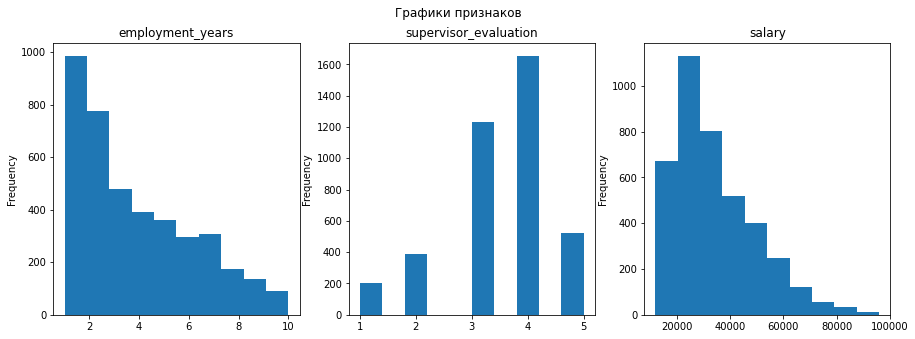

In [57]:
# гистограммы количественных признаков
num_cols = ['employment_years',
            'supervisor_evaluation',
            'salary']

plt_chart(train_q, num_cols, 'hist')

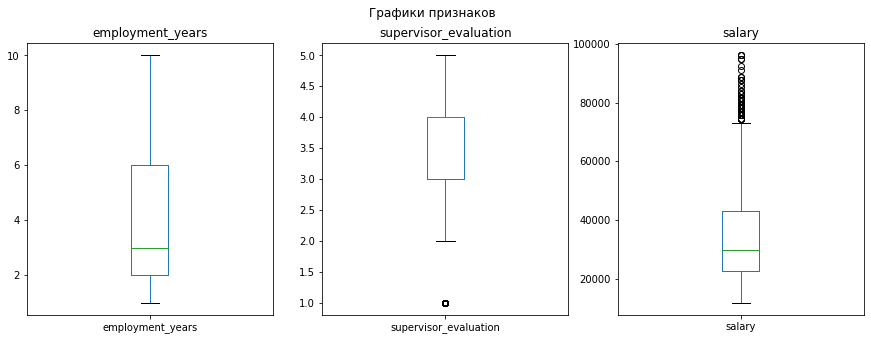

In [58]:
plt_chart(train_q, num_cols, 'box')

In [59]:
# определение количества сотрудников с аномально высокими зарплатами
train_q[train_q['salary'] > (train_q['salary'].median() + 2.5*train_q['salary'].quantile(0.25))]['salary'].count()

12

In [60]:
# удаление аномалий salary
print('Сотрудников до удаления:', len(train_q))
train_q = train_q[train_q['salary'] <= (train_q['salary'].median() + 2.5*train_q['salary'].quantile(0.25))]
print('Сотрудников после удаления:', len(train_q))

Сотрудников до удаления: 4000
Сотрудников после удаления: 3988


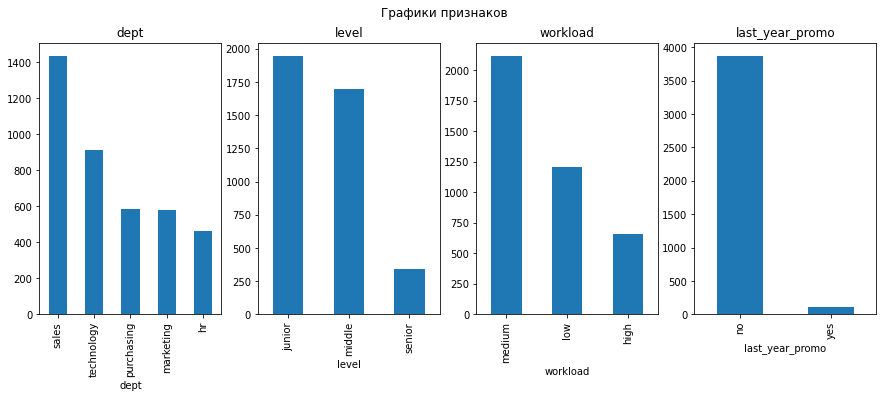

In [61]:
# столбчаты диаграммы категориальных признаков
cat_cols = ['dept',
            'level',
            'workload',
            'last_year_promo']

plt_chart(train_q, cat_cols, kind='bar')

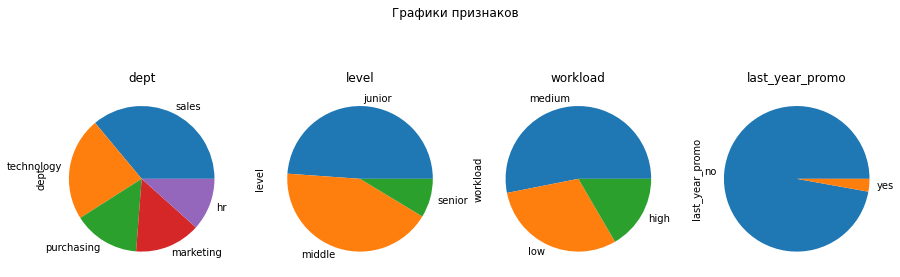

In [62]:
# круговые диаграммы категориальных признаков
plt_chart(train_q, cat_cols, kind='pie')

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'quit']


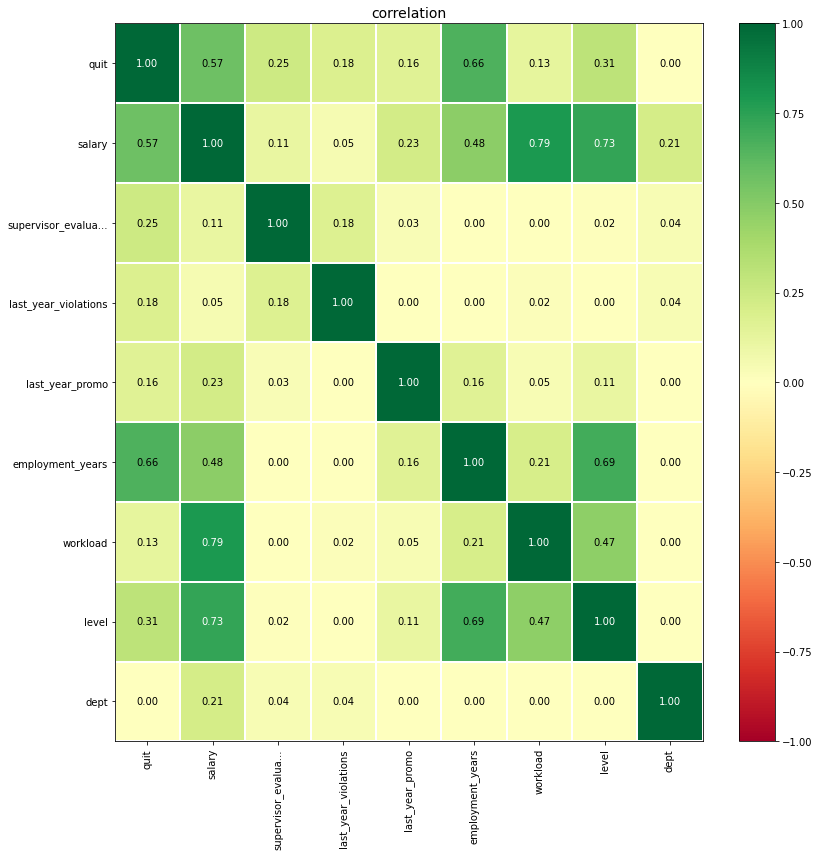

In [63]:
# анализ корреляционных зависимостей между признаками
phik_overview = train_q.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(12, 12)
)

Данные практически не изменились по сравнению с задачей 1

Мультиколлинеарности среди признаков не обнаружено.

Сильнее всего на целевой признак влияют: employment_years и salary

#### 3.2 Портрет уволившегося сотрудника

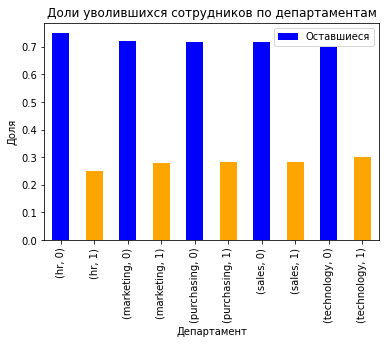

In [64]:
# исследование уволившихся сотрудников по департаменту
train_pvt = train_q.groupby(['dept'])['quit'].value_counts(normalize=True)
bar_colors = ['blue', 'orange'] * 5

#построение графика
train_pvt.plot(kind='bar',
               title='Доли уволившихся сотрудников по департаментам',
               xlabel='Департамент',
               ylabel='Доля',
               color=bar_colors)
plt.legend(['Оставшиеся', 'Уволившиеся'])
plt.show()

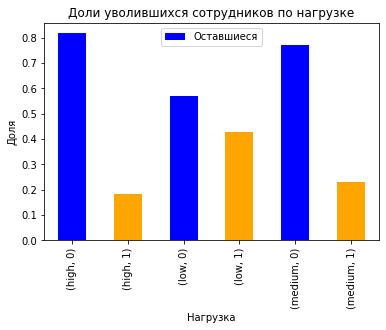

In [65]:
# исследование уволившихся сотрудников по загруженности
train_pvt = train_q.groupby(['workload'])['quit'].value_counts(normalize=True)
bar_colors = ['blue', 'orange'] * 3

#построение графика
train_pvt.plot(kind='bar',
               title='Доли уволившихся сотрудников по нагрузке',
               xlabel='Нагрузка',
               ylabel='Доля',
               color=bar_colors)
plt.legend(['Оставшиеся', 'Уволившиеся'])
plt.show()

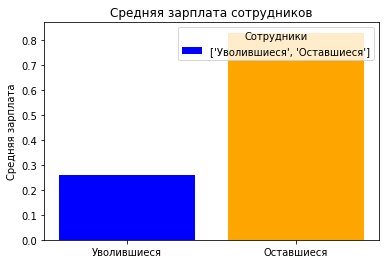

In [66]:
# исследование уволившихся сотрудников по зарплате
train_pvt = train_q.groupby(['salary'])['quit'].value_counts(normalize=True)
quit_mean = train_pvt[train_pvt.index.get_level_values(1) == 1].mean()
stay_mean = train_pvt[train_pvt.index.get_level_values(1) == 0].mean()
cats = ['Уволившиеся', 'Оставшиеся']
salaries = [quit_mean, stay_mean]
bar_colors = ['blue', 'orange']

#построение графика
fig, ax = plt.subplots()

ax.bar(cats, salaries, label=cats, color=bar_colors)

ax.set_ylabel('Средняя зарплата')
ax.set_title('Средняя зарплата сотрудников')
ax.legend(title='Сотрудники')

plt.show()

**Уволившийся сотрудник:**

- доля уволившихся во всех отделах примерно равны
- больше всего увольняются сотрудники с низким уровнем нагрузки
- уровень зарплаты уволившихся сотрудников ниже, чем тех, кто решил остаться в компании

#### 3.3 Проверка связи уровня удовлетворенности с увольнением

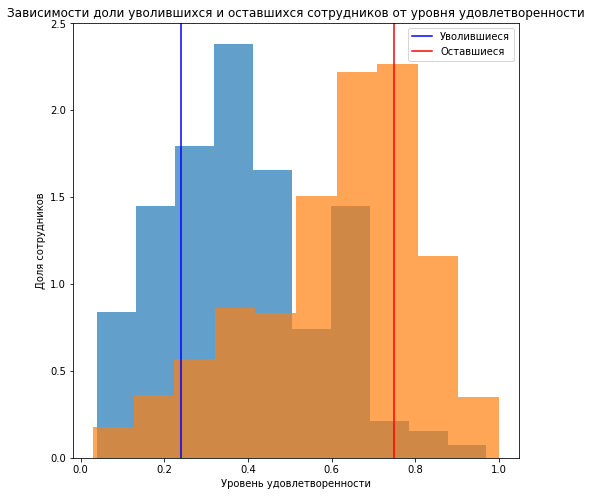

In [67]:
# создание датафрейма для визуализации
sat_quit = target_s.join(target_q)
quit = sat_quit[sat_quit['quit'] == 1]
stay = sat_quit[sat_quit['quit'] == 0]

#построение графика
plt.figure(figsize=(8, 8))
plt.hist(quit['job_satisfaction_rate'], alpha=0.7, density=True)
plt.hist(stay['job_satisfaction_rate'], alpha=0.7, density=True)
plt.axvline(quit['job_satisfaction_rate'].mode()[0], c='blue')
plt.axvline(stay['job_satisfaction_rate'].mode()[0], c='red')
plt.title('Зависимости доли уволившихся и оставшихся сотрудников от уровня удовлетворенности')
plt.ylabel("Доля сотрудников")
plt.xlabel("Уровень удовлетворенности")
plt.legend(["Уволившиеся", "Оставшиеся"])
plt.show()

**Вывод:** Количество уволившихся сотрудников больше при низком уровене удовлетворенности, а оставшихся при высоком. Можно сделать вывод, что уровень удовлетворенности уволившихся сотрудников ниже чем у оставшихся.

<a id='section_id12'></a>
### Шаг 4. Добавление нового входного признака
[к содержанию](#section_id)

In [68]:
# добавление признака 'уровень удовлетворенности'
satisfaction_probe = grid_search.predict(train_q)
train_q['job_satisfaction_rate'] = satisfaction_probe
display(train_q.head(2))

satisfaction_probe = grid_search.predict(test_q)
test_q['job_satisfaction_rate'] = satisfaction_probe
display(test_q.head(2))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0,0.666667
814010,sales,junior,medium,2,no,no,4,27600,0,0.846364


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.885000
686555,hr,junior,medium,1,no,no,4,30000,0.681429


<a id='section_id13'></a>
### Шаг 5. Подготовка данных
[к содержанию](#section_id)

In [69]:
# задание тренировочной и тестовой выборки
X_train = train_q.drop(['quit'], axis=1).sort_index()
X_test = test_q.sort_index()
y_train = train_q['quit'].sort_index()
y_test = target_q.sort_index()

X_train.shape, X_test.shape

((3988, 9), (2000, 9))

In [70]:
# создание списков с названиями признаков
ohe_columns = ['dept',
              'last_year_promo',
              'last_year_violations']
ord_columns = ['level',
               'workload']
num_columns = ['employment_years',
               'supervisor_evaluation',
               'salary',
               'job_satisfaction_rate']

In [71]:
# пайплайн для кодирования ohe_columns + SimpleImputer для заполнения пропусков
ohe_pipe = Pipeline(
    [
     ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [72]:
# пайплайн для кодирования ord_columns + SimpleImputer для заполнения пропусков
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(categories=[['junior', 'middle', 'senior'],
                                         ['low', 'medium', 'high']],
                             handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )

In [73]:
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

<a id='section_id14'></a>
### Шаг 6. Обучение модели
[к содержанию](#section_id)

In [74]:
# итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [75]:
# задание параметров для пайплайна
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_features': range(6, 9),
        'models__max_depth': range(20, 22),
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(6, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(10, 12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
]

In [76]:
# инициализация подбора параметров
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [77]:
# настройка библиотеки для работы с многопоточными вычислениями
joblib.parallel_backend('threading')

In [78]:
# запуск подбора параметров
start_time = time.time()
grid_search.fit(X_train, y_train)
total_time = time.time() - start_time

print(f"Время поиска: {total_time:.2f} seconds")
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Время поиска: 40.40 seconds
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',


In [79]:
# вывод лучших моделей
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)

params_top_10 = results.iloc[0:10]['params']
for param in params_top_10:
    print(param)

{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 20, 'models__max_features': 6, 'models__min_samples_leaf': 6, 'models__min_samples_split': 2, 'preprocessor__num': StandardScaler()}
{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 20, 'models__max_features': 6, 'models__min_samples_leaf': 6, 'models__min_samples_split': 3, 'preprocessor__num': StandardScaler()}
{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 21, 'models__max_features': 6, 'models__min_samples_leaf': 6, 'models__min_samples_split': 4, 'preprocessor__num': StandardScaler()}
{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 20, 'models__max_features': 6, 'models__min_samples_leaf': 6, 'models__min_samples_split': 4, 'preprocessor__num': StandardScaler()}
{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 21, 'models__max_features': 6, 'models__min_samples_leaf': 6, 'models__min_samples_split': 3, 'preproce

**Анализ результатов:** Лучше всего с задачей справляются модели наиболее сложные модели DecisionTreeClassifier. Более простым моделям сложно уловить закономерности, чтобы обеспечить заданный уровень метрики roc_auc

In [80]:
# расчет метрики на тестовой выборке
probabilities = grid_search.best_estimator_.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.9222833817341315


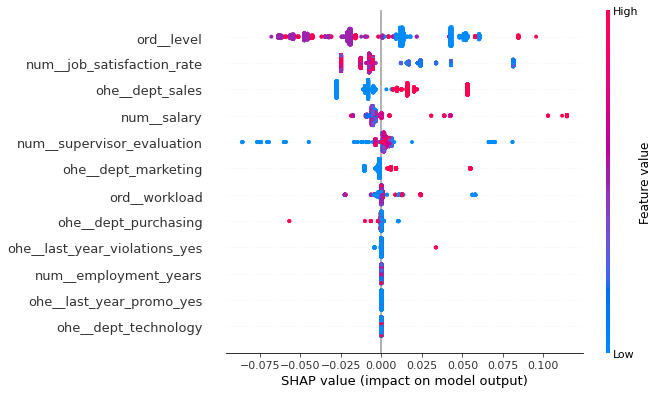

In [81]:
# построение графика важности признаков модели на основе shap
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.Explainer(grid_search.best_estimator_.named_steps['models'], X_train_2)
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

shap_values = explainer(X_test_2, check_additivity=False)

shap.plots.beeswarm(shap_values[:,:,1], max_display=20) 

Удалим малозначимые признаки для улучшения качества обучения модели:

last_year_promo

In [82]:
# обновление списков с названиями признаков
ohe_columns = ['dept',
              'last_year_violations']
ord_columns = ['level',
               'workload']
num_columns = ['salary',
               'employment_years',
               'supervisor_evaluation',
               'job_satisfaction_rate']

In [83]:
# определение новых датасетов X_train, X_test
X_train = X_train[ohe_columns + ord_columns + num_columns]
X_test = X_test[ohe_columns + ord_columns + num_columns]

In [84]:
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [85]:
# итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [86]:
# инициализация подбора параметров
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [87]:
# настройка библиотеки для работы с многопоточными вычислениями
joblib.parallel_backend('threading')

In [88]:
# запуск подбора параметров
start_time = time.time()
grid_search.fit(X_train, y_train)
total_time = time.time() - start_time

print(f"Время поиска: {total_time:.2f} seconds")
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Время поиска: 33.87 seconds
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept',
                                                   'last_year_violations']),
                                                 ('ord',
                   

In [89]:
# расчет метрики на тестовой выборке
probabilities = grid_search.best_estimator_.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.921905559177384


<a id='section_id15'></a>
### Шаг 7. Выводы
[к содержанию](#section_id)

Лучше всего с задачей №2 справилась модель DecisionTreeClassifier(max_depth = 20, max_features = 8, min_samples_leaf = 7). С помощью shap, был проведён отбор признаков, отбросили малозначимый признак last_years_promo. С помощью достаточно сложной модели удалось добиться результата в 0.92 значения метрики roc_auc на тестовой выборке. Дальнейшее улучшение значений метрики возможно при увеличении тренировочной выборки, добавлении признаков. В тренировочной выборке присутствовал дисбаланс классов, объектов класса 0 в 2 раза больше, чем объектов класса 1. Был произведен андерсэмплинг, что позвлило немного улучшить метрику.

<a id='section_id16'></a>
### Общий вывод
[к содержанию](#section_id)

В ходе выполнения работы над проектом решалось 2 задачи:

1. Задача регрессии, по прогнозу количественного целевого признака удовлетворенности сотрудника,
2. Задача классификации, по прогнозу увольнения сотрудника с добавлением нового признака, с помощью предсказаний разработанной модели регресии.

Была выполнена предобработка данных: в задаче регрессии были вручную устранены дубликаты, аномальные значения зарплат. Обработка пропусков и неопознанных значений была проведена в пайплайне вместе с подбором параметров модели. В задаче классификации было принято не удалять дубликаты, так как для задач классификации это не так критично.

На этапе подготовки был собран итоговый пайплайн для обработки данных и обучения модели: для обработки подбирали варианты с двумя способами масштабирования количественных признаков, для задачи регрессии варьировали параметры регуляризации для линейной регрессии, а также параметры глубины, количества признаков для DecisionTreeRegressor. В результате получилось добиться показателя метрики SMAPE 14.75. Для задачи классификации победила модель DecisionTreeclassifier, удалось добиться значения метрики roc_auc 0.89.

После обучения каждой модели была проанализирована важность признаков с помощью библиотеки shap. В задаче регрессии для уровня удовлетворенности оказались важны признаки: supervisor_evaluation, employment_years, salary, level, last_year_violations. В задаче классификации для целевого признака увольнения сотрудников: job_satisfaction_rate, workload, salary.

Был составлен портрет увольняющегося сотрудника: 
- сотрудник отдела sales и technology
- уровня middle
- с относительно низким уровнем зарплаты